## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from IPython.display import Audio
# import resampy

# Data Preparation

In [33]:
# TRAINING STARTS HERE

path_to_features = "../../features2.csv"
Features = pd.read_csv(path_to_features)

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# ANYTHING BELOW CAN BE DELETED, DO YOUR MAGIC FROM THIS POINT ON

In [34]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [37]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104, 1), (3240, 8), (1080, 1104, 1), (1080, 8))

# Modelling

In [38]:

model = Sequential()

# Convolutional Layer
model.add(Conv1D(64, 5, padding='same',
                 input_shape=(x_train.shape[1], 1),
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))

model.add(Activation('relu'))
model.add(Dropout(0.3))

# Global Average Pooling
model.add(Flatten())
model.add(BatchNormalization())  # Batch Normalization before activation
# Dense Layer with Batch Normalization
model.add(Dense(8, kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.001)))
model.add(BatchNormalization())  # Batch Normalization before activation
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1104, 64)          384       
                                                                 
 activation_10 (Activation)  (None, 1104, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 1104, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 70656)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 70656)            282624    
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 8)                 565256    
                                                      

In [39]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
# print(tf.test.is_built_with_cudnn())

True


In [40]:
epochs = 300
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.9, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=350, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/300
10/10 [==============================] - 1s 42ms/step - loss: 3.1100 - accuracy: 0.3670 - val_loss: 3.3500 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 2/300
10/10 [==============================] - 0s 22ms/step - loss: 2.6380 - accuracy: 0.5176 - val_loss: 3.1128 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 3/300
10/10 [==============================] - 0s 22ms/step - loss: 2.2282 - accuracy: 0.6293 - val_loss: 2.8361 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 4/300
10/10 [==============================] - 0s 22ms/step - loss: 1.8950 - accuracy: 0.7102 - val_loss: 2.6505 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 5/300
10/10 [==============================] - 0s 22ms/step - loss: 1.6471 - accuracy: 0.7772 - val_loss: 2.5890 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 6/300
10/10 [==============================] - 0s 22ms/step - loss: 1.4861 - accuracy: 0.8330 - val_loss: 2.5656 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 7/300
10/10 [==============================] - 0s 21ms/step - lo

 1/34 [..............................] - ETA: 1s - loss: 0.5248 - accuracy: 1.0000

34/34 [==============================] - 0s 11ms/step - loss: 0.6743 - accuracy: 0.8861
Accuracy of our model on test data :  88.61111402511597 %
300
300
300


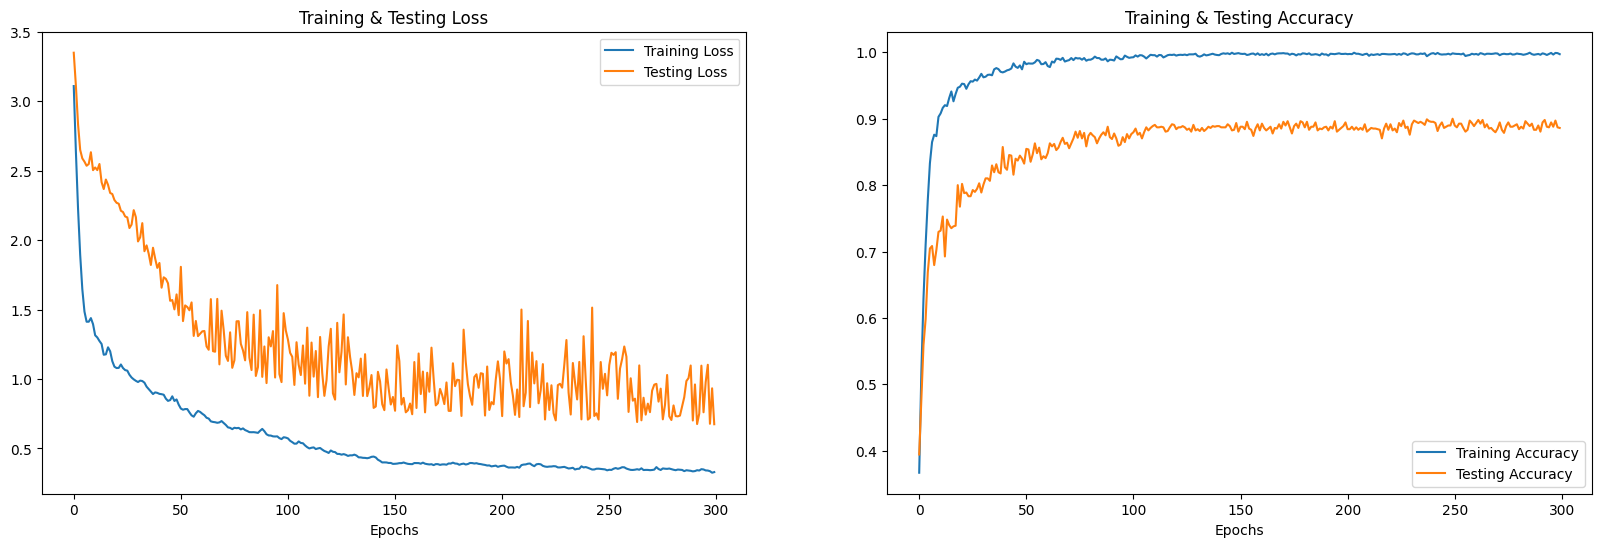

In [41]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

print(len(train_loss))
print(len(test_acc))
print(len(test_loss))


fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [42]:
# predicting on test data.
pred_test = model.predict(x_test)
# print(pred_test)

pred_list = []
categories = [category for category in encoder.categories_][0]
for preds in pred_test:
    pred_dict = {}
    for cat,pred in zip(categories,preds):
        pred_dict[cat]=pred
    pred_list.append(pred_dict)
print(pred_list)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 12ms/step
[{'angry': 0.010235658, 'calm': 0.01781355, 'disgust': 0.02084667, 'fear': 0.7833467, 'happy': 0.06827961, 'neutral': 0.023806356, 'sad': 0.065541334, 'surprise': 0.010130051}, {'angry': 0.7321398, 'calm': 0.0334942, 'disgust': 0.0926757, 'fear': 0.05364505, 'happy': 0.03563351, 'neutral': 0.008056576, 'sad': 0.016769616, 'surprise': 0.027585473}, {'angry': 0.04274923, 'calm': 0.038858783, 'disgust': 0.025998548, 'fear': 0.3758849, 'happy': 0.2601786, 'neutral': 0.020530205, 'sad': 0.052213237, 'surprise': 0.18358651}, {'angry': 0.010525944, 'calm': 0.7654002, 'disgust': 0.011871459, 'fear': 0.0076846723, 'happy': 0.016417235, 'neutral': 0.1584115, 'sad': 0.003358283, 'surprise': 0.0263307}, {'angry': 0.83765334, 'calm': 0.008792766, 'disgust': 0.028245045, 'fear': 0.022592975, 'happy': 0.037375145, 'neutral': 0.012191706, 'sad': 0.040564176, 'surprise': 0.012584911}, {'angry': 0.03573902, 'calm': 0.1352338, 'disgust': 0.03362206, '

In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,calm,calm
4,angry,angry
5,surprise,surprise
6,fear,fear
7,happy,happy
8,fear,fear
9,sad,sad


[array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)]


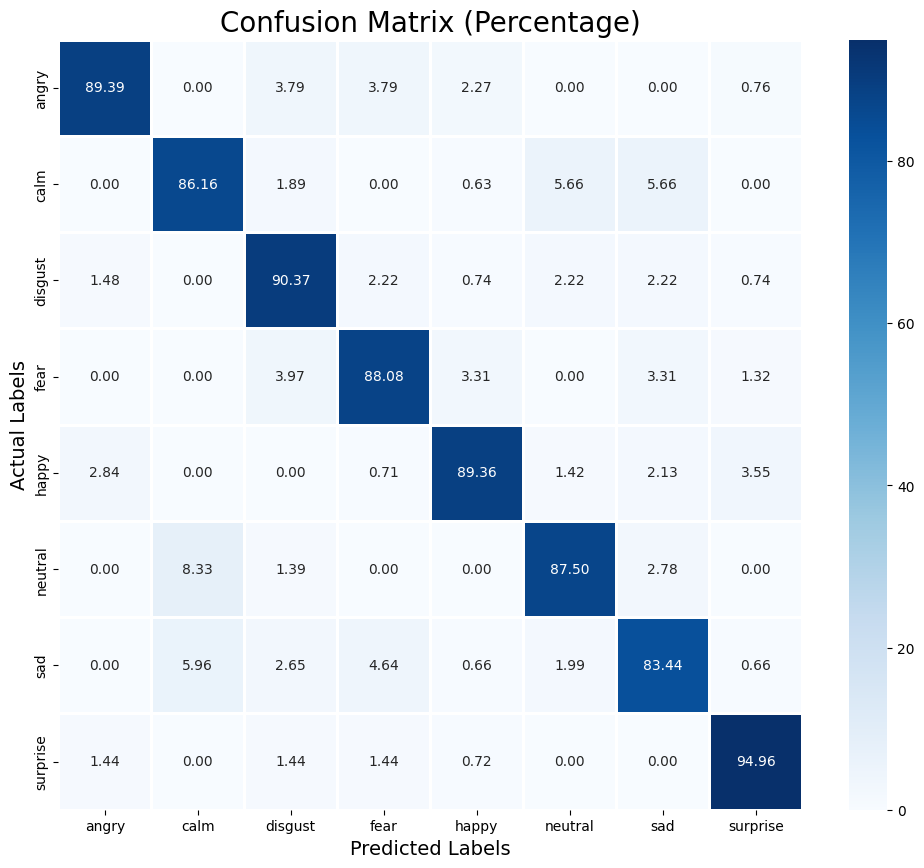

In [44]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix.
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize = (12, 10))

# Convert categories of the encoder to a list for indexing and columns
categories = [category for category in encoder.categories_]
print(categories)
cm_df = pd.DataFrame(cm_percentage, index=categories, columns=categories)
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')

plt.title('Confusion Matrix (Percentage)', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.94      0.89      0.91       132
        calm       0.90      0.86      0.88       159
     disgust       0.85      0.90      0.88       135
        fear       0.88      0.88      0.88       151
       happy       0.91      0.89      0.90       141
     neutral       0.79      0.88      0.83        72
         sad       0.85      0.83      0.84       151
    surprise       0.93      0.95      0.94       139

    accuracy                           0.89      1080
   macro avg       0.88      0.89      0.88      1080
weighted avg       0.89      0.89      0.89      1080



In [47]:
model.save("../../models/cnn/sam_280923_v3.h5")

# Live Demo

SyntaxError: unterminated string literal (detected at line 5) (884998337.py, line 5)